In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [2]:
full_df = pd.read_csv('stats_0z.csv')

event = "tornado"
df = full_df[full_df["event"] == event].copy()
df.index = range(len(df))
df

,event,days_count,threshold,spc_threshold_days,nadocast_threshold_days,spc_success_ratio,spc_pod,spc_false_positive_rate,nadocast_success_ratio,nadocast_pod,...,spc_pod_0.975_bootstrap,spc_csi_0.025_bootstrap,spc_csi_0.975_bootstrap,nadocast_success_ratio_0.025_bootstrap,nadocast_success_ratio_0.975_bootstrap,nadocast_pod_0.025_bootstrap,nadocast_pod_0.975_bootstrap,nadocast_csi_0.025_bootstrap,nadocast_csi_0.975_bootstrap,p_value_nadocast_csi_better
0,tornado,155,0.01,79,115,0.059523,0.698779,0.025721,0.053505,0.869162,...,0.800514,0.038655,0.078670,0.038525,0.069963,0.795803,0.918322,0.038166,0.069417,0.923028
1,tornado,155,0.02,79,95,0.059523,0.698779,0.025721,0.078714,0.778767,...,0.800489,0.038641,0.078710,0.056571,0.101627,0.674510,0.852150,0.055178,0.099669,0.000000
2,tornado,155,0.05,34,51,0.139708,0.412009,0.005910,0.184460,0.510947,...,0.568049,0.068865,0.157571,0.131549,0.230780,0.335539,0.648080,0.105990,0.201115,0.000069
3,tornado,155,0.10,9,17,0.262528,0.173505,0.001135,0.346902,0.225244,...,0.289610,0.039951,0.167735,0.196908,0.458138,0.072275,0.361922,0.057580,0.237541,0.063598
4,tornado,155,0.15,3,8,0.365153,0.089459,0.000362,0.286627,0.026679,...,0.183350,0.000000,0.143967,0.118634,0.513235,0.001448,0.052485,0.001436,0.047604,0.949514
5,tornado,155,0.30,0,1,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,tornado,155,0.45,0,0,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
7,tornado,155,0.60,0,0,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


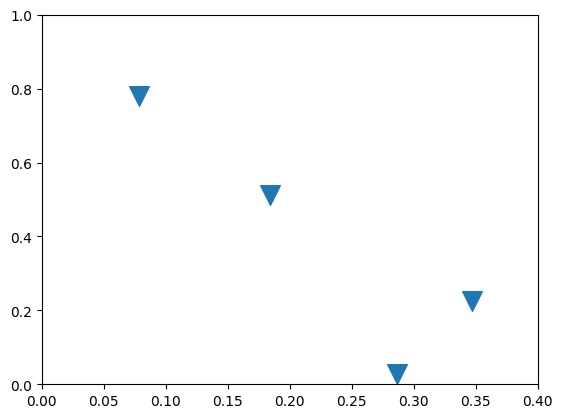

In [3]:
min_threshold = 0.02
nc_or_spc = "nadocast"
fig, ax = plt.subplots()
ax.set_xlim(0,.4)
ax.set_ylim(0,1)
row_is = (df[f"{nc_or_spc}_threshold_days"] >= 2) & (df["threshold"] >= min_threshold)
xs = list(df[f"{nc_or_spc}_success_ratio"][row_is])
ys = list(df[f"{nc_or_spc}_pod"][row_is])
ax.scatter(xs, ys, s=200, marker="v")
plt.show()

In [4]:
alpd = 0.0
last_y = 0.0
areas = []
# work in reverse order
for (x,y) in zip(xs[::-1],ys[::-1]):
    rect_area = x * (y - last_y) 
    areas.append(rect_area)
    last_y = y
areas

[0.007646825686352321,
 0.0688827375472485,
 0.052700744757495,
 0.021081221320278]

In [5]:
alpd = sum(areas)
alpd

0.15031152931137381

In [16]:
# via Sam Mason https://stackoverflow.com/a/56974893
def sig_figs(x, ndigits):
    if x == 0 or not math.isfinite(x):
        return x
    ndigits -= math.ceil(math.log10(abs(x)))
    return round(x, ndigits)

sig_figs(0.04336916143280999,3)

0.0434

In [17]:
def mean2(a, b):
    return (a + b) / 2.0

In [7]:
# Stairstep version
def alpd(csv_path, nc_or_spc, event, min_threshold, max_threshold=1.0):
    full_df = pd.read_csv(csv_path)

    df = full_df[full_df["event"] == event].copy()
    df.index = range(len(df))
    row_is = (df[f"{nc_or_spc}_threshold_days"] >= 2) & (df["threshold"] >= min_threshold) & (df["threshold"] <= max_threshold)
    xs = list(df[f"{nc_or_spc}_success_ratio"][row_is])
    xs = [0.0 if np.isnan(x) else x for x in xs]
    ys = list(df[f"{nc_or_spc}_pod"][row_is])
    last_y = 0.0
    areas = []
    # work in reverse order
    for (x,y) in zip(xs[::-1],ys[::-1]):
        rect_area = x * (y - last_y) 
        areas.append(rect_area)
        last_y = y
    return sum(areas), 4

In [8]:
alpd("stats_0z.csv", "nadocast", "wind", 0.02)

0.3195

In [21]:
for (event, min_threshold) in [("tornado", 0.02), ("wind", 0.05), ("wind_adj", 0.05), ("hail", 0.05)]:
    cells                 = [event]
    spc_0z                = alpd("stats_0z.csv", "spc",                           event, min_threshold)
    nc_0z                 = alpd("stats_0z.csv", "nadocast",                      event, min_threshold)
    nc_href_only_0z       = alpd("stats_0z_href_only.csv", "nadocast",            event, min_threshold)
    nc_2021_0z            = alpd("csvs_2021/stats_0z.csv", "nadocast",            event, min_threshold)
    nc_2021_href_only_0z  = alpd("csvs_2021/stats_0z_href_only.csv", "nadocast",  event, min_threshold)
    spc_12z               = alpd("stats_12z.csv", "spc",                          event, min_threshold)
    nc_12z                = alpd("stats_12z.csv", "nadocast",                     event, min_threshold)
    nc_href_only_12z      = alpd("stats_12z_href_only.csv", "nadocast",           event, min_threshold)
    nc_2021_12z           = alpd("csvs_2021/stats_12z.csv", "nadocast",           event, min_threshold)
    nc_2021_href_only_12z = alpd("csvs_2021/stats_12z_href_only.csv", "nadocast", event, min_threshold)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_2021_0z, 3))
    cells.append(sig_figs(nc_2021_href_only_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_2021_12z, 3))
    cells.append(sig_figs(nc_2021_href_only_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_0z, nc_2021_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_href_only_0z, nc_2021_href_only_12z), 3))
    print(",".join(map(str, cells)))

tornado,0.105,0.15,0.148,0.138,0.139,0.136,0.171,0.17,0.162,0.167,0.12,0.161,0.159,0.15,0.153
wind,0.196,0.308,0.312,0.3,0.305,0.237,0.334,0.34,0.34,0.344,0.216,0.321,0.326,0.32,0.324
wind_adj,0.0763,0.139,0.144,0,0,0.0928,0.167,0.166,0,0,0.0845,0.153,0.155,0.0,0.0
hail,0.102,0.195,0.196,0.193,0.193,0.129,0.224,0.224,0.221,0.223,0.116,0.21,0.21,0.207,0.208


In [24]:
for event in ["sig_tornado", "sig_wind", "sig_wind_adj", "sig_hail"]:
    cells = [event]
    spc_0z                = alpd("stats_0z.csv", "spc",                           event, 0.1, 0.1)
    nc_0z                 = alpd("stats_0z.csv", "nadocast",                      event, 0.1, 0.1)
    nc_href_only_0z       = alpd("stats_0z_href_only.csv", "nadocast",            event, 0.1, 0.1)
    nc_2021_0z            = alpd("csvs_2021/stats_0z.csv", "nadocast",            event, 0.1, 0.1)
    nc_2021_href_only_0z  = alpd("csvs_2021/stats_0z_href_only.csv", "nadocast",  event, 0.1, 0.1)
    spc_12z               = alpd("stats_12z.csv", "spc",                          event, 0.1, 0.1)
    nc_12z                = alpd("stats_12z.csv", "nadocast",                     event, 0.1, 0.1)
    nc_href_only_12z      = alpd("stats_12z_href_only.csv", "nadocast",           event, 0.1, 0.1)
    nc_2021_12z           = alpd("csvs_2021/stats_12z.csv", "nadocast",           event, 0.1, 0.1)
    nc_2021_href_only_12z = alpd("csvs_2021/stats_12z_href_only.csv", "nadocast", event, 0.1, 0.1)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_2021_0z, 3))
    cells.append(sig_figs(nc_2021_href_only_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_2021_12z, 3))
    cells.append(sig_figs(nc_2021_href_only_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_0z, nc_2021_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_href_only_0z, nc_2021_href_only_12z), 3))
    print(",".join(map(str, cells)))

sig_tornado,0.0434,0.0634,0.0655,0.0588,0.0578,0.0527,0.0809,0.0764,0.0679,0.0726,0.048,0.0722,0.071,0.0633,0.0652
sig_wind,0.0113,0.0267,0.0239,0.0258,0.0255,0.0221,0.0416,0.0435,0.046,0.0447,0.0167,0.0342,0.0337,0.0359,0.0351
sig_wind_adj,0.00703,0.0111,0.0115,0,0,0.0121,0.0105,0.0166,0,0,0.00958,0.0108,0.0141,0.0,0.0
sig_hail,0.0111,0.0378,0.0428,0.0336,0.0346,0.0272,0.0493,0.0529,0.0406,0.0423,0.0191,0.0435,0.0478,0.0371,0.0385


In [11]:
print(",".join(["", "0600 SPC", "0Z NC", "1630 SPC", "12Z NC"]))
ablation_events = ["tornado_mean_58", "tornado_prob_80", "tornado_mean_prob_138", "tornado_mean_prob_computed_no_sv_219", "tornado_mean_prob_computed_220", "tornado_mean_prob_computed_partial_climatology_227", "tornado_mean_prob_computed_climatology_253", "tornado_mean_prob_computed_climatology_blurs_910", "tornado_mean_prob_computed_climatology_grads_1348", "tornado_mean_prob_computed_climatology_blurs_grads_2005", "tornado_mean_prob_computed_climatology_prior_next_hrs_691", "tornado_mean_prob_computed_climatology_3hr_1567", "tornado_full_13831"]
for event in ablation_events:
    cells = [event]
    cells.append(alpd("stats_0z_href_ablations.csv", "spc", event, 0.02))
    cells.append(alpd("stats_0z_href_ablations.csv", "nadocast", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations.csv", "spc", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations.csv", "nadocast", event, 0.02))
    print(",".join(map(str, cells)))


,0600 SPC,0Z NC,1630 SPC,12Z NC
tornado_mean_58,0.1051,0.1218,0.1355,0.1471
tornado_prob_80,0.1051,0.1347,0.1355,0.1584
tornado_mean_prob_138,0.1051,0.137,0.1355,0.1722
tornado_mean_prob_computed_no_sv_219,0.1051,0.131,0.1355,0.1732
tornado_mean_prob_computed_220,0.1051,0.1343,0.1355,0.1726
tornado_mean_prob_computed_partial_climatology_227,0.1051,0.1385,0.1355,0.1758
tornado_mean_prob_computed_climatology_253,0.1051,0.1494,0.1355,0.1838
tornado_mean_prob_computed_climatology_blurs_910,0.1051,0.1541,0.1355,0.1868
tornado_mean_prob_computed_climatology_grads_1348,0.1051,0.1422,0.1355,0.1838
tornado_mean_prob_computed_climatology_blurs_grads_2005,0.1051,0.1438,0.1355,0.1857
tornado_mean_prob_computed_climatology_prior_next_hrs_691,0.1051,0.1464,0.1355,0.188
tornado_mean_prob_computed_climatology_3hr_1567,0.1051,0.1385,0.1355,0.1805
tornado_full_13831,0.1051,0.1482,0.1355,0.1703


In [15]:
print(",".join(["", "Feature Count", "0Z", "12Z"]))
ablation_events = ["tornado_mean_58", "tornado_prob_80", "tornado_mean_prob_138", "tornado_mean_prob_computed_no_sv_219", "tornado_mean_prob_computed_220", "tornado_mean_prob_computed_partial_climatology_227", "tornado_mean_prob_computed_climatology_253", "tornado_mean_prob_computed_climatology_blurs_910", "tornado_mean_prob_computed_climatology_grads_1348", "tornado_mean_prob_computed_climatology_blurs_grads_2005", "tornado_mean_prob_computed_climatology_prior_next_hrs_691", "tornado_mean_prob_computed_climatology_3hr_1567", "tornado_full_13831"]
import re
for event in ablation_events:
    cells = [event, re.compile(r"_(\d+)$").search(event)[1]]
    cells.append(alpd("stats_0z_href_ablations_absolutely_calibrated.csv", "nadocast", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations_absolutely_calibrated.csv", "nadocast", event, 0.02))
    print(",".join(map(str, cells)))


,Feature Count,0Z,12Z
tornado_mean_58,58,0.1304,0.1539
tornado_prob_80,80,0.1384,0.1657
tornado_mean_prob_138,138,0.1482,0.1804
tornado_mean_prob_computed_no_sv_219,219,0.1376,0.1762
tornado_mean_prob_computed_220,220,0.1401,0.1775
tornado_mean_prob_computed_partial_climatology_227,227,0.1476,0.1842
tornado_mean_prob_computed_climatology_253,253,0.1605,0.1947
tornado_mean_prob_computed_climatology_blurs_910,910,0.159,0.1923
tornado_mean_prob_computed_climatology_grads_1348,1348,0.1514,0.1914
tornado_mean_prob_computed_climatology_blurs_grads_2005,2005,0.149,0.193
tornado_mean_prob_computed_climatology_prior_next_hrs_691,691,0.1577,0.2015
tornado_mean_prob_computed_climatology_3hr_1567,1567,0.1558,0.1925
tornado_full_13831,13831,0.1548,0.1826
